In [1]:
print("reset")

reset


In [3]:
import xarray as xr
import numba
import matplotlib.pyplot as plt
import subprocess
#from Algorithms.HelicopterTriggerIndex import *

In [4]:
#ds = xr.open_dataset("http://thredds.met.no/thredds/dodsC/meps25epsarchive/2018/10/01/meps_extracted_2_5km_20181001T00Z.nc")
#ds1 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/mepsarchive/2019/12/09/cmeps_det_2_5km_20191209T06Z.nc")
#HTI = xr.open_dataset("http://thredds.met.no/thredds/dodsC/meps25epsarchive/2019/10/01/meps_mbr0_pp_2_5km_20191001T06Z.nc")["helicopter_triggered_index"]


In [11]:
k = 0
infile=open("extracted_paths.txt")
# Either list or string
variables = ['precipitation_amount_acc']
files = sorted(infile.readlines())
for file in files:
    # Define date from filepath
    file = file.strip()
    date = file[-15:-3]
    #filename = "https://thredds.met.no/thredds/dodsC/meps25epsarchive" + file[-48:]
    outfile = "source_disk/MEPS/extracted_variables/test"+file[-16:]
    exitcode = subprocess.call(["fimex","--input.file="+file,"--output.file="+outfile,"-c","configfiles/extracted.cfg"])
    if  exitcode != 0:
        print(file,outfile,exitcode)
    
    k +=1
    if k % 20 == 0:
        print(len(files)- k)
#https://thredds.met.no/thredds/dodsC/meps25epsarchive/2017/01/23/meps_extracted_2_5km_20170123T12Z.nc

fimex --input.file=/lustre/storeB/immutable/archive/projects/metproduction/meps/2019/10/14/meps_extracted_2_5km_20191014T00Z.nc --output.file=source_disk/MEPS/extracted_variables/test_20191014T00Z.nc -c configfiles/extracted.cfg
/lustre/storeB/immutable/archive/projects/metproduction/meps/2019/10/14/meps_extracted_2_5km_20191014T00Z.nc source_disk/MEPS/extracted_variables/test_20191014T00Z.nc 1


In [5]:
HTIat10Local = HTI.isel(time=10)

fig, ax2 = plt.subplots()
HTIat10Local.plot(ax = ax2)


NameError: name 'HTI' is not defined

In [7]:
def fetchfields(xarray,timeindex):
    # Fetch fields used for operational HTI - post proccessing
    geo_pl = xarray["geopotential_pl"].isel(time=timeindex)
    geo_sf = xarray["surface_geopotential"].isel(time=timeindex)
    airtemp_pl = xarray["air_temperature_pl"].isel(time=timeindex)
    rhs_pl = xarray["relative_humidity_pl"].isel(time=timeindex)
    upward_pl = xarray["upward_air_velocity_pl"].isel(time=timeindex)

    lowcloud = xarray["low_type_cloud_area_fraction"].isel(time=timeindex)
    prec = xarray["precipitation_amount_acc"].isel(time=timeindex)

    return  geo_pl, geo_sf, airtemp_pl, rhs_pl, upward_pl, lowcloud, prec


In [8]:
geo_pl, geo_sf, airtemp_pl, rhs_pl, upward_pl, lowcloud, prec = fetchfields(ds,10)

In [9]:
def get_height_value_from_pl(geopotential_pl,variable_pl,height=750):
    # Assume 925 to 850 band always has interesting heights. May need changing later
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    z2,z1 = geopotential_pl.sel(pressure=850)/9.81 , geopotential_pl.sel(pressure=925)/9.81
    v2,v1 = variable_pl.sel(pressure=850) , variable_pl.sel(pressure=925)
    variableperheight = (v2-v1)/(z2-z1)
    result = v1 + variableperheight*(height - z1)
    return result


In [10]:
air_temp = get_height_value_from_pl(geo_pl,airtemp_pl-273.15)
W_ = get_height_value_from_pl(geo_pl,upward_pl)


In [11]:
new_ds = xr.Dataset(  {
        "air_temp": (("ensemble_member","y", "x"), air_temp),
        "W_": (("ensemble_member","y", "x"), W_),
        "geo_sf": (("ensemble_member","y", "x"), geo_sf.values[0]),
        "prec": (("ensemble_member","y", "x"),prec.values[0]),
        "lowcloud": (("ensemble_member","y", "x"), lowcloud.values[0]),
     },
     coords={'ensemble_member':ds.ensemble_member, 'x': ds.x,'y': ds.y},
) 


In [12]:
new_ds.to_netcdf("source/test.nc")

In [13]:
new_ds = xr.open_dataset("source/test.nc")
W_ = new_ds["W_"]
air_temp = new_ds["air_temp"]
prec = new_ds["prec"]
lowcloud = new_ds["lowcloud"]
geo_sf = new_ds["geo_sf"]

In [14]:
@numba.jit
def neighbourhood_max(xarrayvalues,neigbhoursize = 3):
    N = neigbhoursize
    # Assume incoming object to be numpy array
    X,Y = xarrayvalues.shape
    result = np.zeros((X,Y))
    # First fill non-trivial parts
    for y in range(N,Y-N + 1+1):
        for x in range(N,X-N + 1+1):
            result[x,y] = np.max(xarrayvalues[x-N:x+N + 1,y-N:y+N + 1])
    for i in range(N):
        for y in range(Y):
            result[i,y] = xarrayvalues[i,y]
            result[-(1+i),y] = xarrayvalues[-(1+i),y]
        for x in range(X):
            result[x,i] = xarrayvalues[x,i]
            result[x,-(1+i)] = xarrayvalues[x,-(1+i)]
    return result

@numba.jit
def neighbourhood_min(xarrayvalues,neigbhoursize = 3):
    N = neigbhoursize
    # Assume incoming object to be numpy array
    X,Y = xarrayvalues.shape
    result = np.zeros((X,Y))
    # First fill non-trivial parts
    for y in range(N,Y-N + 1+1):
        for x in range(N,X-N + 1+1):
            result[x,y] = np.min(xarrayvalues[x-N:x+N + 1,y-N:y+N + 1])
    for i in range(N):
        for y in range(Y):
            result[i,y] = xarrayvalues[i,y]
            result[-(1+i),y] = xarrayvalues[-(1+i),y]
        for x in range(X):
            result[x,i] = xarrayvalues[x,i]
            result[x,-(1+i)] = xarrayvalues[x,-(1+i)]
    return result


In [15]:
Nbh = 7

W = np.zeros_like(W_)
topomin = np.zeros_like(W)
topomax = np.zeros_like(topomin)
cl = np.zeros_like(lowcloud)
pc = np.zeros_like(prec)

for member in W_["ensemble_member"]:
    W[member] = neighbourhood_max(W_.isel(ensemble_member=member).values,Nbh)
    cl[member] = neighbourhood_max(lowcloud.isel(ensemble_member=member).values,Nbh)
    cl[member] -= neighbourhood_min(lowcloud.isel(ensemble_member=member).values,Nbh)
    pc[member] = neighbourhood_max(prec.isel(ensemble_member=member).values,Nbh)
    topomax[member] = neighbourhood_max(geo_sf.isel(ensemble_member=member).values,Nbh)
    topomin[member] = neighbourhood_min(geo_sf.isel(ensemble_member=member).values,Nbh)


In [16]:
tfunc = temperature_max_band_from_b_to_c(-1,-6)

def only_positive_but_no_larger_than_1(array):
    size = array.shape
    result = np.zeros(size)
    result[np.where(array > 0)] = np.minimum(1.5*array[np.where(array>0)],1)
    return result

def only_positive_but_no_larger_than_1_with_scaling(topoarray,scaling = 15000):
    def f(array):
        size = array.shape
        result = np.zeros(size)
        result[np.where(array > 0) and np.where(topoarray < 10)] = np.minimum(1.5*array[np.where(array>0) and np.where(topoarray < 10)],1)
        scalingfactor = 1-(topoarray[np.where(array>0) and np.where(topoarray>10)]/scaling)
        result[np.where(array > 0) and np.where(topoarray > 10)] = np.minimum(scalingfactor*1.5*array[np.where(array > 0) and np.where(topoarray > 10)],1)
        result[np.where(result < 0)] = 0
        return result
    return f
wfunc = only_positive_but_no_larger_than_1_with_scaling(topomax)
pfunc = only_positive_but_no_larger_than_1
cfunc = lambda x: x

In [17]:
HTI = HelicopterTriggerIndex([tfunc,wfunc,pfunc,cfunc])
result = HTI([air_temp.values,W,pc,cl])

result[np.where(topomax >= 7500)] = 0
result[np.where(topomin >= 10)] = 0
def mask(array,topmax=topomax,topmin=topomin):
    array[np.where(topmax >= 7500)] = 0
    array[np.where(topmin >= 10)] = 0
    return array

In [18]:
T = mask(tfunc(air_temp.values))
Wn = mask(wfunc(W))
P = mask(pfunc(pc))
C = mask(cfunc(cl))

In [19]:
new_ds=new_ds.assign(HTI=((("ensemble_member","y", "x")),result))
new_ds=new_ds.assign(T=((("ensemble_member","y", "x")),T))
new_ds=new_ds.assign(W=((("ensemble_member","y", "x")),Wn))
new_ds=new_ds.assign(P=((("ensemble_member","y", "x")),P))
new_ds=new_ds.assign(C=((("ensemble_member","y", "x")),C))

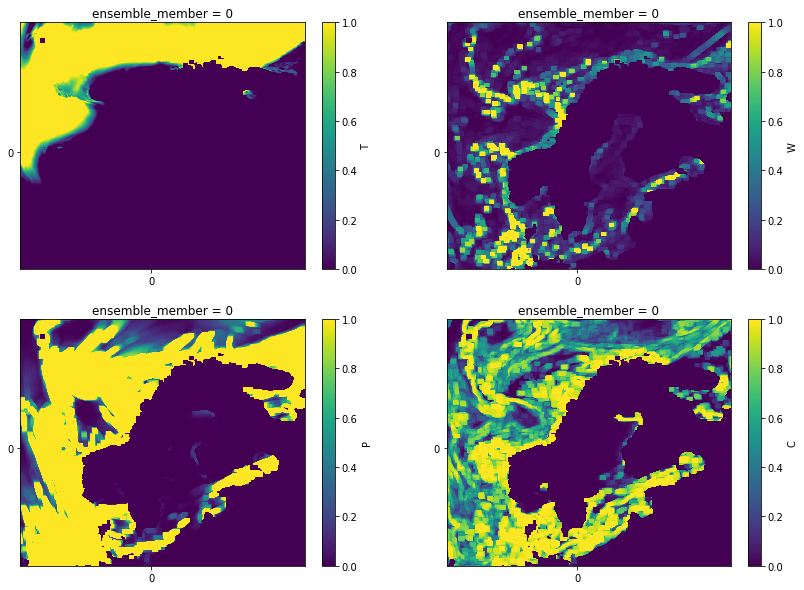

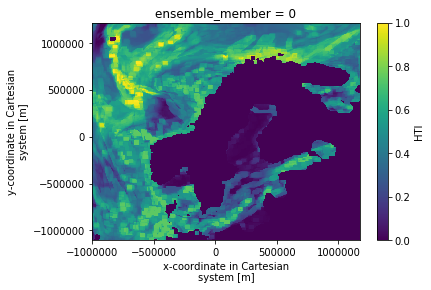

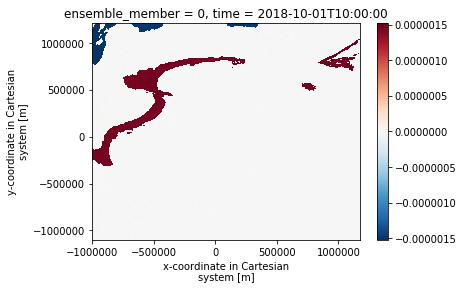

In [25]:
fig,ax = plt.subplots(2,2,figsize=(14,10))

new_ds["T"].sel(ensemble_member=0).isel(x=range(10,889-10),y = range(10,949-10)).plot(ax = ax[0][0])
new_ds["W"].sel(ensemble_member=0).isel(x=range(10,889-10),y = range(10,949-10)).plot(ax = ax[0][1])
new_ds["P"].sel(ensemble_member=0).isel(x=range(10,889-10),y = range(10,949-10)).plot(ax = ax[1][0])
new_ds["C"].sel(ensemble_member=0).isel(x=range(10,889-10),y = range(10,949-10)).plot(ax = ax[1][1])
for x in ax:
    x[0].set_xticks(range(0,1))
    x[0].set_xlabel("")
    x[1].set_xlabel("")
    x[0].set_ylabel("")
    x[1].set_ylabel("")
    x[1].set_xticks(range(0,1))
    x[0].set_yticks(range(0,1))
    x[1].set_yticks(range(0,1))
    
fig, ax1 = plt.subplots()

new_ds["HTI"].sel(ensemble_member=0).isel(x=range(10,889-10),y = range(10,949-10)).plot(ax=ax1)

fig, ax2 = plt.subplots()

(new_ds["HTI"].sel(ensemble_member=0).isel(x=range(10,889-10),y = range(10,949-10))-HTIat10Local).plot(ax=ax2)

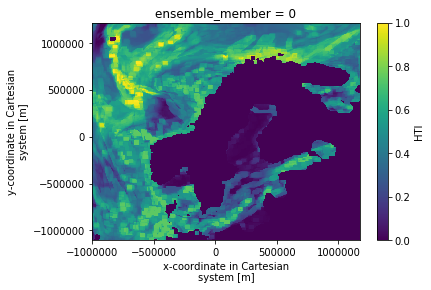

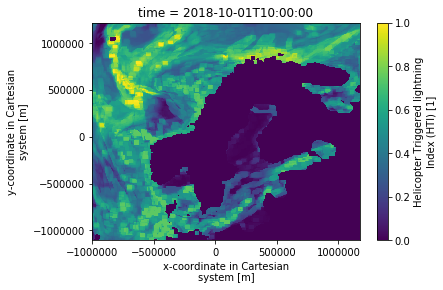

In [21]:
fig, ax1 = plt.subplots()

new_ds["HTI"].sel(ensemble_member=0).isel(x=range(10,889-10),y = range(10,949-10)).plot(ax = ax1)

fig, ax2 = plt.subplots()

HTIat10Local.plot(ax = ax2)

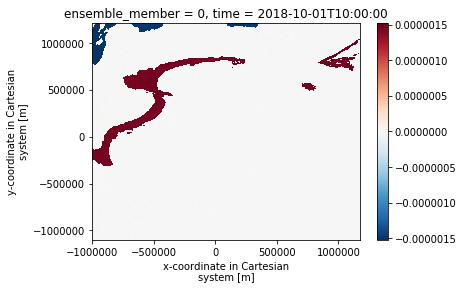

In [22]:
fig, ax1 = plt.subplots()

(new_ds["HTI"].sel(ensemble_member=0).isel(x=range(10,889-10),y = range(10,949-10)) - HTIat10Local).plot(ax = ax1)

Text(0.5,1,'Ensemble Min')

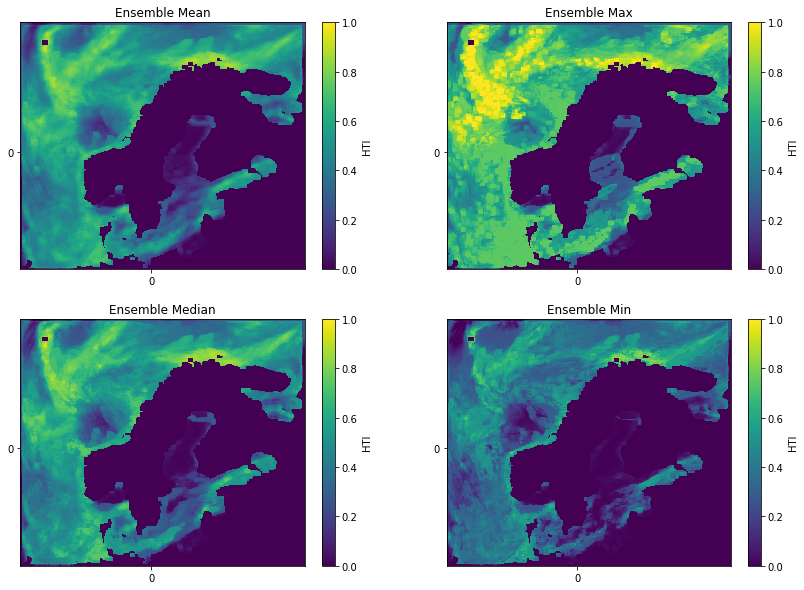

In [23]:
fig, ax = plt.subplots(2,2,figsize=(14,10))


new_ds["HTI"].mean("ensemble_member").plot(ax = ax[0][0],vmax=1.0,vmin = 0)
new_ds["HTI"].median("ensemble_member").plot(ax = ax[1][0],vmax=1.0,vmin=0)
new_ds["HTI"].max("ensemble_member").plot(ax = ax[0][1],vmax=1.0,vmin = 0)
new_ds["HTI"].min("ensemble_member").plot(ax = ax[1][1],vmax=1.0,vmin=0)
for x in ax:
    x[0].set_xticks(range(0,1))
    x[0].set_xlabel("")
    x[1].set_xlabel("")
    x[0].set_ylabel("")
    x[1].set_ylabel("")
    x[1].set_xticks(range(0,1))
    x[0].set_yticks(range(0,1))
    x[1].set_yticks(range(0,1))
ax[0][0].set_title("Ensemble Mean")
ax[0][1].set_title("Ensemble Max")
ax[1][0].set_title("Ensemble Median")
ax[1][1].set_title("Ensemble Min")
